# Getting started with relay-bp

This guide assumes you have installed Relay-BP as described in the [Readme](../README.md) with the Stim option. For example:

```bash
pip install -e ".[stim]"
```

## Core python API
Below we show how to use the core Relay Python API. Later in the notebook we show how to use the Sinter API for easy integration with [Stim](https://github.com/quantumlib/Stim).

In the example below we import `relay_bp`. Setup a check matrix for a simple repetition code and decode some syndromes.

In [1]:
import relay_bp
import numpy as np
from scipy.sparse import csr_matrix

# Decoding problem specification
check_matrix = csr_matrix(np.asarray([
    [1, 1, 0],
    [0, 1, 1],
])) # detectors x error variables
error_priors = np.array([0.003, 0.003, 0.003], dtype=np.float64) # Set the priors probability for each error

# Decoder configuration
gamma0 = 0.1                      # Uniform memory weight for the first ensemble
pre_iter = 80                      # Max BP iterations for the first ensemble 
num_sets=100                       # Number of relay ensemble elements
set_max_iter = 60                 # Max BP iterations per relay ensemble
gamma_dist_interval=(-0.24, 0.66)  # Set the uniform distribution range for disordered memory weight selection
stop_nconv=5                      # Number of relay solutions to find before stopping (the best will be selected) 

relay_decoder = relay_bp.RelayDecoderF32(
    check_matrix,                                   
    error_priors=error_priors,
    gamma0=gamma0,
    pre_iter=pre_iter,
    num_sets=num_sets,
    set_max_iter=set_max_iter,
    gamma_dist_interval=gamma_dist_interval,
    stop_nconv=stop_nconv,
)

detectors = np.array([1, 1], dtype=np.uint8)

decoding = relay_decoder.decode(detectors)

print(f"For the detectors {detectors} the decoded errors were {decoding}")

For the detectors [1 1] the decoded errors were [0 1 0]


#### Detailed decoding results can be retrieved from the decoder to aid in analysis

In [2]:
decoding_detailed = relay_decoder.decode_detailed(detectors)

print(f"Detectors: {decoding_detailed.decoded_detectors}")
print(f"Predicted errors: {decoding_detailed.decoding}")
print(f"BP iterations executed: {decoding_detailed.iterations}")
print(f"Converged to input detectors: {decoding_detailed.success}")
print(f"Posterior error log-likelihood ratios: {decoding_detailed.posterior_ratios}")

Detectors: [1 1]
Predicted errors: [0 1 0]
BP iterations executed: 3
Converged to input detectors: True
Posterior error log-likelihood ratios: [  2.1364038  -13.43175411   6.47129679]


#### We can decode a batch of syndromes in parallel

In [3]:
detector_batch = np.array([[0, 1], [1, 0], [1, 1]], dtype=np.uint8) # shots x detectors

decoding = relay_decoder.decode_batch(detector_batch)
print(decoding)

[[0 0 1]
 [1 0 0]
 [0 1 0]]


#### There is a utility class `ObservableDecoderRunner` to help run and evaluate logical decoding 

It takes an input decoder instance and observable error matrix.

In [4]:
observable_error_matrix = np.asarray([[1, 1, 1]], dtype=np.uint8) # observables x error variables

observable_decoder = relay_bp.ObservableDecoderRunner(relay_decoder, observable_error_matrix)

#### It supports evaluating decoding results in parallel

In [5]:
detector_batch = np.array([[0, 1], [1, 0], [1, 1]], dtype=np.uint8) # shots x detectors

decoding = observable_decoder.decode_batch(detector_batch, parallel=True)
print(decoding)

[[0 0 1]
 [1 0 0]
 [0 1 0]]


#### `ObservableDecoderRunner` can be used to decode and compute logical observables

As well as compare the predicted observable against the true input observable.

#### The class will also compute the trial outcomes for you 

In [6]:
errors = np.array([ # shots x errors
    [0, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 0],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 1],
], dtype=np.uint8)

true_observables = ((observable_error_matrix @ errors.T) % 2).T

decoded_observables = observable_decoder.from_errors_decode_observables_batch(errors, parallel=True)

decoding_failures = np.sum(true_observables != decoded_observables)

logical_error_rate = decoding_failures / len(errors)

print(f"The logical error rate is {logical_error_rate}")

The logical error rate is 0.5


#### The class will also compute the trial outcomes for you 

In [7]:
decoded_observables_detailed = observable_decoder.from_errors_decode_observables_detailed_batch(errors, parallel=True)

decoding_failures = np.sum([result.error_detected for result in decoded_observables_detailed])

logical_error_rate = decoding_failures / len(errors)

print(f"The logical error rate is {logical_error_rate}")

The logical error rate is 0.5


#### The logical decoding result contains additional decoding information

Set `include_decode_result=True` to also include the syndrome level decoding result. Note, this can consume large amounts of memory if batch decoding. 

In [8]:
decoded_observable = decoded_observables_detailed[1]

print(f"Decoder converged to solution that agrees with detectors: {decoded_observable.converged}")
print(f"Decoder converged after iterations: {decoded_observable.iterations}")
print(f"Decoded observables: {decoded_observable.observables}")
print(f"Decoder observable prediction disagrees with the true observable: {decoded_observable.error_detected}")
print(f"Triggered error variables predicted by the decoder differ from the true physical-level errors: {decoded_observable.error_mismatch_detected}")

Decoder converged to solution that agrees with detectors: True
Decoder converged after iterations: 3
Decoded observables: [1]
Decoder observable prediction disagrees with the true observable: False
Triggered error variables predicted by the decoder differ from the true physical-level errors: False


## Decoding with Stim

The `relay_bp` package includes support for reading in circuits from Stim. This includes manual setup of the `ObservableDecoderRunner` as well as integration with `sinter`.

Below we load a test gross from the built in [`testdata`](../tests/testdata) circuits and setup a `ObservableDecoderRunner` for it to perform Relay-BP decoding. 

#### We can manually load the circuit, compile the DEM and extract the decoder information

In [9]:
from relay_bp.stim import CheckMatrices

import sys
from pathlib import Path
sys.path.append(str(Path("../tests").resolve()))
from testdata import filter_detectors_by_basis, get_test_circuit

basis = "Z"
n = 144
k = 12
d = 12
rounds = d
circuit = f"bicycle_bivariate_{n}_{k}_{d}_memory_{basis}"
error_rate = 0.003

bb_circuit = get_test_circuit(circuit=circuit, distance=d, rounds=d, error_rate=error_rate)
# Set true to improve decoding performance with Relay through correlated errors
XYZ_decoding = False

if not XYZ_decoding:
    # Extract sub-circuits for the observables we want to decode in a CSS-like manner
    # with only detectors kept from our selected basis
    bb_circuit = filter_detectors_by_basis(bb_circuit, basis)

bb_dem = bb_circuit.detector_error_model()

bb_check_matrices = CheckMatrices.from_dem(bb_dem)

bb_sampler = bb_dem.compile_sampler()

bb_shots = 10000

circ_detector_data, circ_obs_data, errors = bb_sampler.sample(bb_shots, return_errors=True)

relay_bb_decoder = relay_bp.RelayDecoderF32(
    bb_check_matrices.check_matrix,                                   
    error_priors=bb_check_matrices.error_priors,
    gamma0=0.1,
    pre_iter=80,
    num_sets=60,
    set_max_iter=60,
    gamma_dist_interval=(-0.24, 0.66),
    stop_nconv=1,
)

bb_observable_decoder = relay_bp.ObservableDecoderRunner(relay_bb_decoder, bb_check_matrices.observables_matrix)

bb_decode_results = bb_observable_decoder.from_errors_decode_observables_detailed_batch(errors.astype(np.uint8), parallel=True, progress_bar=True)
bb_decoding_failures = np.sum([result.error_detected for result in bb_decode_results])
bb_logical_error_rate = (bb_decoding_failures / bb_shots)/(rounds*k)

#print(f"Check matrix contains {bb_check_matrices.check_matrix.shape[0]} detectors and {bb_check_matrices.check_matrix.shape[1]} error variables")
#print(f"Logical error rate per round/qubit with p={error_rate} is {bb_logical_error_rate}")

#### Or we can use the builtin [`sinter`](https://github.com/quantumlib/Stim/tree/main/glue/sample) decoder integration to run an experiment 


In [10]:
import sinter
import multiprocessing
from relay_bp.stim import sinter_decoders
from relay_bp.stim.sinter.utils import write_stats

num_workers = multiprocessing.cpu_count()

basis = "Z"
circuit_strs = [f"bicycle_bivariate_{n}_{k}_{d}_memory_{basis}"]

error_rates = np.linspace(0.002, 0.005, 4)

# Disable to rerun the data
# Depending on the machine, this may take a few hours to run. Consider turning down the Relay values or the number of shots
save_load = True

# Note: These parameters were tuned for the gross ([[144,12,12]] code and
# may yield different performance with different code parameters.
# See the other notebooks in the repository for examples on how to tune these
# values.

decoder_params = dict(
    gamma0=0.1,
    pre_iter=80,
    num_sets=300,
    set_max_iter=60,
    gamma_dist_interval=[-0.24, 0.66],
    stop_nconv=5,
)
decoders = sinter_decoders(
    **decoder_params
)

def select_num_shots(p, decoder):
    if decoder != "relay-bp":
        return 500
    if p >= 0.005:
        return 500
    elif p < 0.005 and p >= 0.004:
        return 1_000
    elif p < 0.004 and p >= 0.003:
        return 5_000
    elif p < 0.003 and p >= 0.002:
        return 20_000
    return 100_000

def generate_sinter_tasks():
    for circuit_str in circuit_strs: 
        for error_rate in error_rates:
            circuit = get_test_circuit(circuit=circuit_str, distance=d, rounds=rounds, error_rate=error_rate,)
            for XYZ in [True, False]:
                if not XYZ:
                    circuit = filter_detectors_by_basis(circuit, basis)
                dem = circuit.detector_error_model()
                for decoder in decoders.keys():
                    yield sinter.Task(
                        circuit=circuit,
                        detector_error_model=dem,
                        decoder=decoder,
                        json_metadata={
                            "circuit": circuit_str,
                            "p": error_rate,
                            "n": n,
                            "k": k,
                            "d": d,
                            "r": rounds,
                            "xyz": XYZ,
                            "decoder_params": decoder_params,
                        },
                        collection_options=sinter.CollectionOptions(max_shots=select_num_shots(error_rate, decoder))
                    )

# Collect the samples (takes a few minutes).
save_file = "data/stim_getting_started.csv" if save_load else None
samples = sinter.collect(
        tasks=generate_sinter_tasks(),
        num_workers=num_workers, 
        custom_decoders=decoders,
        print_progress=True,
        save_resume_filepath=save_file,
   )

if save_load:
    # Save consolidated samples rather than each job for disksize reasons
    write_stats(samples, save_file)

Starting 96 workers...


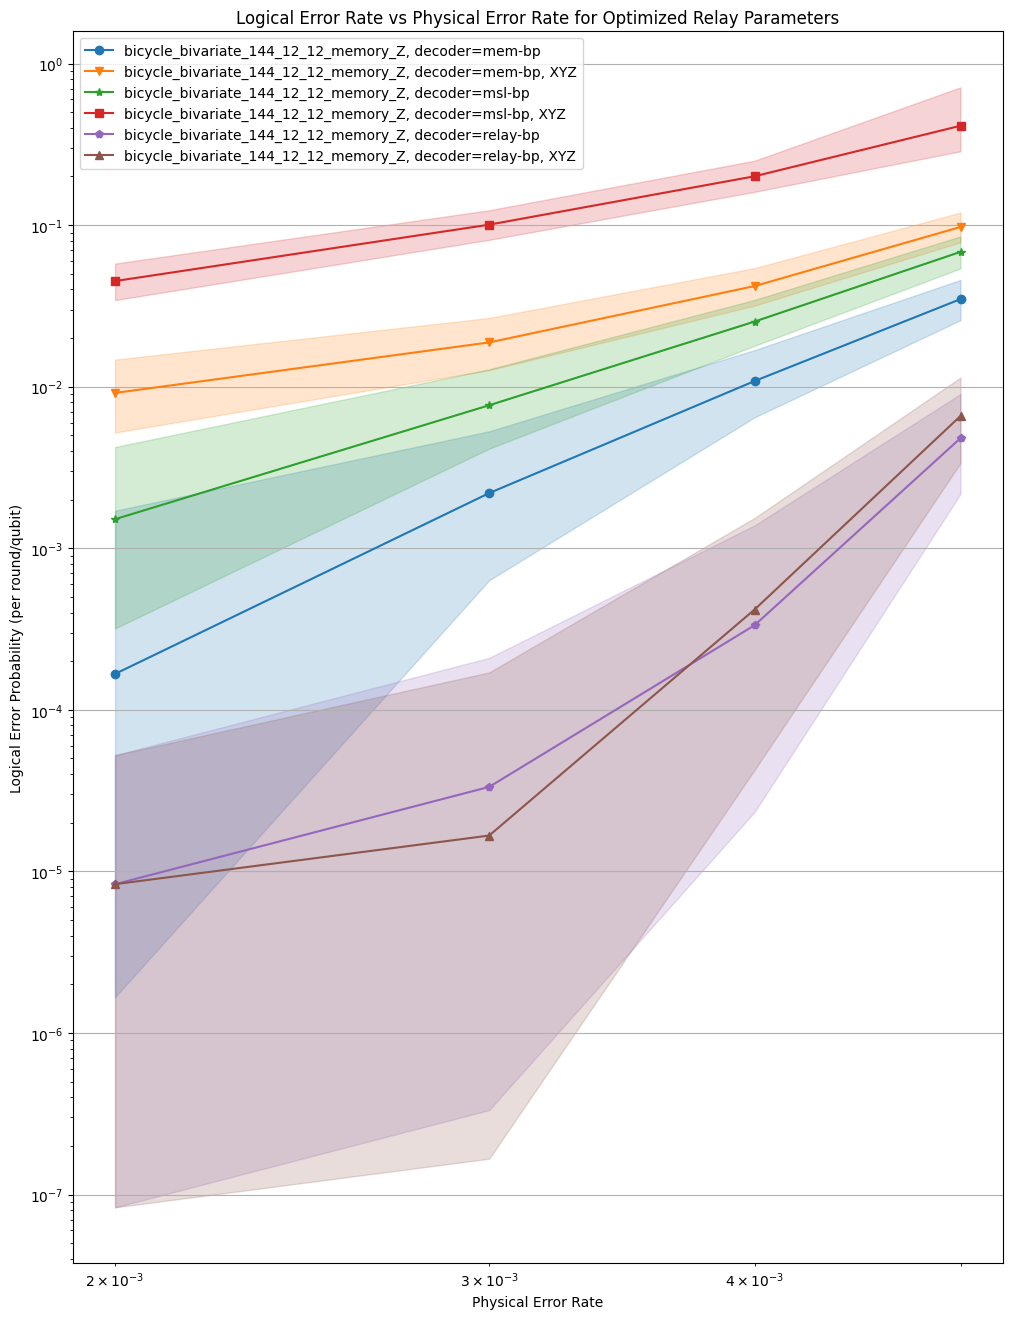

In [11]:
import matplotlib.pyplot as plt

# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1, figsize=(12, 16))
sinter.plot_error_rate(
    ax=ax,
    stats=samples,
    group_func=lambda stat: f"""{stat.json_metadata["circuit"]}, decoder={stat.decoder}{", XYZ" if stat.json_metadata["xyz"] else ""}""",
    x_func=lambda stat: stat.json_metadata["p"],
    failure_units_per_shot_func=lambda stats: stats.json_metadata["d"],
    failure_values_func=lambda stats: stats.json_metadata['k'],
    filter_func=lambda stat: stat.json_metadata["decoder_params"] == decoder_params and stat.json_metadata["circuit"] in circuit_strs

)
ax.loglog()
ax.grid()
ax.set_title(f"Logical Error Rate vs Physical Error Rate for Optimized Relay Parameters")
ax.set_ylabel("Logical Error Probability (per round/qubit)")
ax.set_xlabel("Physical Error Rate")
ax.legend()

plt.show()